In [ ]:
"""

Date: April 20, 2022

Author: Karine Choquet

This script will make datasets and plots for Figures 2 and S2-4 of the splicing order manuscript



"""

In [1]:
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

import math

import pybedtools
from pybedtools import BedTool

from collections import Counter

import random


import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr
from scipy.stats import chi2_contingency

import itertools

from statsmodels.stats.multitest import multipletests

from more_itertools import consecutive_groups

from tqdm import tqdm

import random
from numpy.random import choice

## Supplemental Tables and data for plotting in R

In [2]:
# Load intron features and gene_names df
hg38_intron_df = pd.read_table("/path/to/annotation_files/hg38_all_intron_features.txt")
gene_names_df = pd.read_table("/path/to/annotation_files/hg38_UCSC_refGene_names.txt")
gene_names_df.columns = ['gene_name','gene_id']

hg38_intron_df['gene_id'] = hg38_intron_df['gene'].str.split("\\.").str[0]

gene_names_df = gene_names_df.merge(hg38_intron_df, on='gene_id')[['gene_name','gene','intron_total']].drop_duplicates().reset_index(drop=True)

hg38_intron_coord = hg38_intron_df.copy()[['chrom','start','end','gene','intron_pos']]




In [3]:
# Load results from cluster from identifying splicing order paths in both replicates
path_df_tmp = pd.read_table('/path/to/K562_chromatin_splicing_paths_non_consecutive_introns.2mergedReps.RefSeq.max4introns.txt')
path_df = path_df_tmp[['sample_name','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)



In [4]:
# Remove duplicates intron groups because they belong to different transcripts
intron_groups = path_df[['gene','gene_name','analyzed_introns','n_analyzed_introns']].drop_duplicates().reset_index(drop=True)

intron_groups_3 = intron_groups[intron_groups['n_analyzed_introns']==3].reset_index(drop=True)
intron_groups_3['int1'] = intron_groups_3['analyzed_introns'].str.split("_").str[0].astype(int)
intron_groups_3['int2'] = intron_groups_3['analyzed_introns'].str.split("_").str[1].astype(int)
intron_groups_3['int3'] = intron_groups_3['analyzed_introns'].str.split("_").str[2].astype(int)

intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

intron_groups_3 = intron_groups_3.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)

intron_groups_4 = intron_groups[intron_groups['n_analyzed_introns']==4].reset_index(drop=True)
intron_groups_4['int1'] = intron_groups_4['analyzed_introns'].str.split("_").str[0].astype(int)
intron_groups_4['int2'] = intron_groups_4['analyzed_introns'].str.split("_").str[1].astype(int)
intron_groups_4['int3'] = intron_groups_4['analyzed_introns'].str.split("_").str[2].astype(int)
intron_groups_4['int4'] = intron_groups_4['analyzed_introns'].str.split("_").str[3].astype(int)

intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})
intron_groups_4 = intron_groups_4.merge(hg38_intron_coord, left_on=['gene','int4'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_4', 'start':'start_4', 'end':'end_4'})

intron_groups_4 = intron_groups_4.sort_values(by=['gene','int1','int2','int3','int4']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3','chrom_4','start_4','end_4']).reset_index(drop=True)

fields = ['gene','gene_name','analyzed_introns','n_analyzed_introns']
intron_groups_nodup = pd.concat([intron_groups_3[fields],intron_groups_4[fields]]).sort_values(by=['gene_name','analyzed_introns']).reset_index(drop=True)

# Merge back with paths
path_df_tmp_nodup = path_df_tmp.merge(intron_groups_nodup, on=['gene','gene_name','analyzed_introns','n_analyzed_introns'])
path_df_nodup = path_df_tmp_nodup[['sample_name','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)

# Reformat the table to have replicates side by side
path_df_rep1 = path_df_nodup[path_df_nodup['sample_name']=='chr_rep1'].reset_index(drop=True)
path_df_rep2 = path_df_nodup[path_df_nodup['sample_name']=='chr_rep2'].reset_index(drop=True)

path_df_piv = path_df_rep1.merge(path_df_rep2, on=['gene_name','gene','analyzed_introns','n_analyzed_introns','full_path'])

# Retrieve the paths that are reproducible (same rank in both samples)
path_df_reprod = path_df_piv[(path_df_piv['rank_x']==path_df_piv['rank_y'])].reset_index(drop=True)


In [5]:
# Convert back into a long format dataframe
path_df_reprod_rep1 = path_df_reprod[['sample_name_x','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score_x','rank_x']].rename(columns={'sample_name_x':'sample_name','full_path_score_x':'full_path_score','rank_x':'rank'})
path_df_reprod_rep2 = path_df_reprod[['sample_name_y','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score_y','rank_y']].rename(columns={'sample_name_y':'sample_name','full_path_score_y':'full_path_score','rank_y':'rank'})

path_df_reprod_m = pd.concat([path_df_reprod_rep1,path_df_reprod_rep2]).reset_index(drop=True)

In [6]:
path_df_reprod_top = path_df_reprod_m[path_df_reprod_m['rank']==1]

print("number of intron groups: ", len(path_df_reprod_top[['gene','gene_name','analyzed_introns']].drop_duplicates()))
print("number of transcripts: ", len(path_df_reprod_top[['gene','gene_name']].drop_duplicates()))
print("number of genes: ", len(path_df_reprod_top[['gene_name']].drop_duplicates()))

number of intron groups:  669
number of transcripts:  448
number of genes:  325


In [41]:
# Get reproducible paths (same path in both replicates)
reprod_paths = path_df_reprod_top[['gene','analyzed_introns']].drop_duplicates().reset_index(drop=True)
path_df_reprod_m_final = path_df_nodup.merge(reprod_paths,on=['gene','analyzed_introns']).sort_values(by=['gene','analyzed_introns','rank']).reset_index(drop=True)

In [44]:
# Write to file for plotting in R
path_df_reprod_m_final.to_csv('/path/to/TableS3_K562_splicing_order_paths.txt', sep="\t", header=True, index=False)


In [45]:
# Load results from random splicing orders
results_df = pd.read_table("/path/to/K562_chromatin_splicing_paths_non_consecutive_introns.2mergedReps.RefSeq.max4introns.random_paths.txt")

In [46]:
# Calculate average splicing order score per replicate
path_df_reprod_final = path_df_reprod_m_final.pivot_table(index=['gene','gene_name','analyzed_introns','n_analyzed_introns','full_path'],columns='sample_name',values='full_path_score').reset_index()
path_df_reprod_final['avg_score'] = path_df_reprod_final[['chr_rep1','chr_rep2']].mean(axis=1)


In [49]:
# Function to calculate Shannon diversity index and Evenness
# Formulas taken from here: https://www.tutorialspoint.com/statistics/shannon_wiener_diversity_index.htm
# https://en.wikipedia.org/wiki/Species_evenness

def SDI(path_scores, max_paths):
    
    H = round(-(np.sum(np.log(path_scores) * path_scores)),2) 
    max_H = round(np.log(max_paths),2)
    
    E = round(H/max_H,2)
    
    return(H, E)
    
    
    

In [50]:
# Calculate Shannon diversity index and Evenness

cand_gene_df2 = path_df_reprod_final[['gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

SDI_list = []

for i in tqdm(range(len(cand_gene_df2))):
    gene = cand_gene_df2.loc[i]['gene']
    gene_name = cand_gene_df2.loc[i]['gene_name']
    analyzed_introns = cand_gene_df2.loc[i]['analyzed_introns']
    
    df = results_df_piv[(results_df_piv['gene']==gene) & (results_df_piv['analyzed_introns']==analyzed_introns)]
    
    n_introns = len(analyzed_introns.split("_"))
    
    path_scores = np.array(df[df['measured']>0]['measured'])
    random_scores = np.array(df[df['random']>0]['random'])
    SS_scores = np.array(df[df['SS_scores']>0]['SS_scores'])
    seq_scores = np.array(df[df['sequential']>0]['sequential'])
    
    approach_dict = {'measured_path':path_scores,'random':random_scores,'SS_score':SS_scores,'1stCome_1stServe':seq_scores}
    
    for approach in approach_dict.keys():
        my_SDI = SDI(approach_dict[approach], math.factorial(n_introns))
        SDI_list.append([gene, gene_name, analyzed_introns, approach, n_introns, my_SDI[0],my_SDI[1]])
        
SDI_df = pd.DataFrame(SDI_list)
SDI_df.columns = ['gene','gene_name','analyzed_introns','approach','n_introns','Shannon_diversity','Evenness']

100%|██████████| 669/669 [00:02<00:00, 291.58it/s]


In [51]:
# Write to file for plotting in R
SDI_df.to_csv("/path/to/splicing_order_paths_random_K562_with_Shannon_index_with100iterations.txt", sep="\t", header=True, index=False)

In [52]:
# Filter for measured or random splicing only (not SS-driven or first-come first-serve)
SDI_df_sub = SDI_df[SDI_df['approach'].isin(['measured_path','random'])].reset_index(drop=True).rename(columns={'Shannon_diversity':'Shannon_index'})

In [53]:
# Write as Supplemental table
SDI_df_sub.to_csv('/path/to/TableS4_K562_splicing_order_evenness.txt', sep="\t", header=True, index=False)


## Splicing order heatmap representations

In [3]:
# Import data
chr3_multi_introns_df = pd.read_table("/path/to/K562_chr_rep3_hg38_multi_introns_isoforms_df.txt")
chr4_multi_introns_df = pd.read_table("/path/to/K562_chr_rep4_hg38_multi_introns_isoforms_df.txt")

chr_multi_introns_df = pd.concat([chr3_multi_introns_df,chr4_multi_introns_df]).reset_index(drop=True)

In [4]:
# For each read, retrieve splicing status for introns in the intron group

def code_intron_status(df, n_introns):
    
    results_list = []
    
    for row in range(len(df)):
        readname = df.loc[row]['read']
        strand = df.loc[row]['strand']
        intron_numbers = df.loc[row]['intron_numbers']
        splice_status_introns = df.loc[row]['splice_status']
    
        intron_numbers_list = intron_numbers.split("_")
        splice_status_list_introns = splice_status_introns.split("_")
    
        new_splice_status_list = [readname]
    
        # Make dictionaries
        intron_dict = {}
    
        for i in range(len(intron_numbers_list)):
            intron_dict[int(intron_numbers_list[i])] = splice_status_list_introns[i]
        
        # Loop through the introns
        for k in range(0,n_introns):
            if k in intron_dict.keys():
                if intron_dict[k] == "YES" or "SKP" in intron_dict[k]:
                    new_splice_status_list.append(-1)
                elif intron_dict[k] == "NO":
                    new_splice_status_list.append(-2)
                else:
                    new_splice_status_list.append(0)
            else:
                new_splice_status_list.append(0)
                        
        results_list.append(new_splice_status_list) 
    
    results_df = pd.DataFrame(results_list)
            
    return(results_df)
            
    
    

In [5]:
# Define color for side bar based on number of introns that have been removed
def get_color(sum_spliced, total_introns):
    
    min_sum = total_introns * -2
    
    if sum_spliced == min_sum:
        color = sns.color_palette("Dark2")[0]
    elif sum_spliced == min_sum +1:
        color = sns.color_palette("Dark2")[1]
    elif sum_spliced == min_sum +2:
        color = sns.color_palette("Dark2")[2]
    elif sum_spliced == min_sum +3:
        color = sns.color_palette("Dark2")[3]
    elif sum_spliced == min_sum +4:
        color = sns.color_palette("Dark2")[4]
    elif sum_spliced == min_sum +5:
        color = sns.color_palette("Dark2")[5]
    elif sum_spliced == min_sum +6:
        color = sns.color_palette("Dark2")[6]
    elif sum_spliced == min_sum +7:
        color = sns.color_palette("Set2")[0]
    elif sum_spliced == min_sum +8:
        color = sns.color_palette("Set2")[1]
    else:
        color = sns.color_palette("Dark2")[7]
        
    return color


In [10]:
DDX39A_df1 = chr_multi_introns_df[(chr_multi_introns_df['gene']=='NM_005804.3') & (chr_multi_introns_df['intron_numbers'].str.contains('2_3_4'))].reset_index(drop=True)
DDX39A_mat1 = code_intron_status(DDX39A_df1, 10)
DDX39A_mat1.index = DDX39A_mat1[0]
DDX39A_mat1 = DDX39A_mat1[[3,4,5]]

DDX39A_mat1['sum_spliced'] = DDX39A_mat1.sum(axis=1)
DDX39A_mat1['level'] = DDX39A_mat1.apply(lambda row: get_color(row.sum_spliced, 3), axis=1)


DDX39A_colors1 = DDX39A_mat1['level']

DDX39A_mat1_bis = DDX39A_mat1.sort_values(by=['sum_spliced',3,4,5])
DDX39A_mat1_bis = DDX39A_mat1_bis.drop(columns=['sum_spliced','level'])


In [11]:
DDX39A_mat1.sort_values(by=['sum_spliced',3,4,5])

,3,4,5,sum_spliced,level
0,,,,,
b85b7fe1-c851-49bf-aa35-109cca82b347,-2,-2,-2,-6,"(0.10588235294117647, 0.6196078431372549, 0.46..."
0c832e23-eaf5-440a-b6c3-8d2ae56b5b48,-2,-2,-2,-6,"(0.10588235294117647, 0.6196078431372549, 0.46..."
99c2e8e9-7443-4a31-b266-d00eaa35edd0,-2,-2,-2,-6,"(0.10588235294117647, 0.6196078431372549, 0.46..."
373989a8-d100-4e14-83ec-6edde395322d,-2,-2,-2,-6,"(0.10588235294117647, 0.6196078431372549, 0.46..."
47fc69c1-47e1-4e52-ad2a-9df4e693f3d4,-2,-2,-2,-6,"(0.10588235294117647, 0.6196078431372549, 0.46..."
...,...,...,...,...,...
1352aeb3-6ef7-48f2-b107-62e5d2e2fb58,-1,-1,-1,-3,"(0.9058823529411765, 0.1607843137254902, 0.541..."
ba230b5a-ec9b-490a-8001-5528a14860d6,-1,-1,-1,-3,"(0.9058823529411765, 0.1607843137254902, 0.541..."
1e550d1f-1405-48b9-9be6-797db6c143d8,-1,-1,-1,-3,"(0.9058823529411765, 0.1607843137254902, 0.541..."


In [12]:
len(DDX39A_mat1[DDX39A_mat1['sum_spliced']==-5])

174

In [13]:
len(DDX39A_mat1[DDX39A_mat1['sum_spliced']==-4])

347

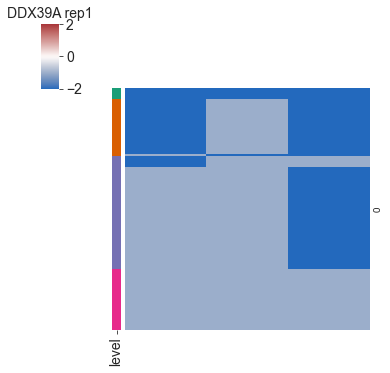

In [17]:
gene_name = "DDX39A"
replicate = "rep1"

sns.clustermap(DDX39A_mat1_bis, col_cluster=False, row_cluster=False, 
               cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,5),
              row_colors=DDX39A_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/Fig2A_K562_chromatin_rep1_DDX39A_read_heatmap_v2.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [18]:
# What if I plot only the introns of interest that go into the analysis?
ACADVL_df1 = chr_multi_introns_df[(chr_multi_introns_df['gene']=='NM_000018.3') &
                                  (chr_multi_introns_df['intron_numbers'].str.contains("7_8_9_10"))].reset_index(drop=True)

ACADVL_mat1 = code_intron_status(ACADVL_df1, 20)
ACADVL_mat1.index = ACADVL_mat1[0]
ACADVL_mat1 = ACADVL_mat1[[8,9,10,11]]

ACADVL_mat1['sum_spliced'] = ACADVL_mat1.sum(axis=1)
ACADVL_mat1['level'] = ACADVL_mat1.apply(lambda row: get_color(row.sum_spliced, 4), axis=1)


ACADVL_colors1 = ACADVL_mat1['level']

ACADVL_mat1_bis = ACADVL_mat1.sort_values(by=['sum_spliced',8,9,10,11])
ACADVL_mat1_bis = ACADVL_mat1_bis.drop(columns=['sum_spliced','level'])


In [19]:
len(ACADVL_mat1[ACADVL_mat1['sum_spliced']==-7])

59

In [20]:
len(ACADVL_mat1[ACADVL_mat1['sum_spliced']==-6])

43

In [21]:
len(ACADVL_mat1[ACADVL_mat1['sum_spliced']==-5])

47

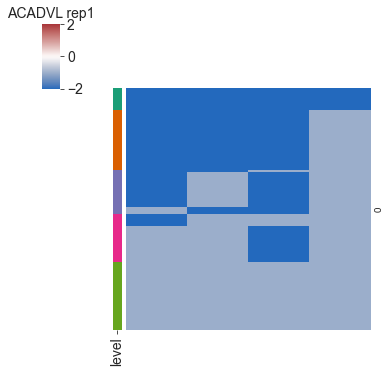

In [22]:
gene_name = "ACADVL"
replicate = "rep1"

sns.clustermap(ACADVL_mat1_bis, col_cluster=False, row_cluster=False, 
               cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,5),
              row_colors=ACADVL_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/Fig2D_K562_chromatin_rep1_ACADVL_read_heatmap_v2.pdf", format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [23]:
# Test with selected genes
PAXX_df1 = chr_multi_introns_df[(chr_multi_introns_df['gene']=='NM_183241.1') &
                                  (chr_multi_introns_df['intron_numbers'].str.contains("0_1_2_3"))].reset_index(drop=True)
PAXX_mat1 = code_intron_status(PAXX_df1, 6)
PAXX_mat1.index = PAXX_mat1[0]
PAXX_mat1 = PAXX_mat1[[1,2,3,4]]

PAXX_mat1['sum_spliced'] = PAXX_mat1.sum(axis=1)
PAXX_mat1['level'] = PAXX_mat1.apply(lambda row: get_color(row.sum_spliced, 4), axis=1)


PAXX_colors1 = PAXX_mat1['level']

PAXX_mat1_bis = PAXX_mat1.sort_values(by=['sum_spliced',1,2,3,4])
PAXX_mat1_bis = PAXX_mat1_bis.drop(columns=['sum_spliced','level'])


In [24]:
len(PAXX_mat1[PAXX_mat1['sum_spliced']==-7])

315

In [25]:
len(PAXX_mat1[PAXX_mat1['sum_spliced']==-6])

384

In [26]:
len(PAXX_mat1[PAXX_mat1['sum_spliced']==-5])

63

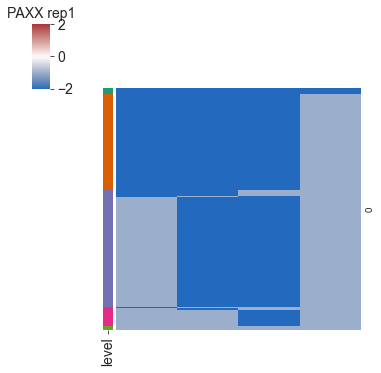

In [27]:
gene_name = "PAXX"
replicate = "rep1"

sns.clustermap(PAXX_mat1_bis, col_cluster=False, row_cluster=False, cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,5),
              row_colors=PAXX_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/Fig2D_K562_chromatin_rep1_PAXX_read_heatmap_v2.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [28]:
# Test with selected genes
FASTK_df1 = chr_multi_introns_df[(chr_multi_introns_df['gene']=='NM_001258461.1') &
                                  (chr_multi_introns_df['intron_numbers'].str.contains("2_3_4_5"))].reset_index(drop=True)
FASTK_mat1 = code_intron_status(FASTK_df1, 8)
FASTK_mat1.index = FASTK_mat1[0]
FASTK_mat1 = FASTK_mat1[[3,4,5,6]]

FASTK_mat1['sum_spliced'] = FASTK_mat1.sum(axis=1)
FASTK_mat1['level'] = FASTK_mat1.apply(lambda row: get_color(row.sum_spliced, 4), axis=1)


FASTK_colors1 = FASTK_mat1['level']

FASTK_mat1_bis = FASTK_mat1.sort_values(by=['sum_spliced',3,4,5,6])
FASTK_mat1_bis = FASTK_mat1_bis.drop(columns=['sum_spliced','level'])


In [29]:
len(FASTK_mat1[FASTK_mat1['sum_spliced']==-7])

46

In [30]:
len(FASTK_mat1[FASTK_mat1['sum_spliced']==-6])

69

In [31]:
len(FASTK_mat1[FASTK_mat1['sum_spliced']==-5])

110

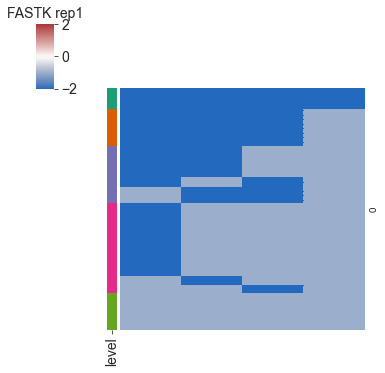

In [32]:
gene_name = "FASTK"
replicate = "rep1"

sns.clustermap(FASTK_mat1_bis, col_cluster=False, row_cluster=False, cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,5),
              row_colors=FASTK_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/Fig2D_K562_chromatin_rep1_FASTK_read_heatmap_v2.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

In [33]:
# Test with selected genes
MAT2A_df1 = chr_multi_introns_df[(chr_multi_introns_df['gene']=='NM_005911.5') &
                                  (chr_multi_introns_df['intron_numbers'].str.contains("4_5_6_7"))].reset_index(drop=True)
MAT2A_mat1 = code_intron_status(MAT2A_df1, 8)
MAT2A_mat1.index = MAT2A_mat1[0]
MAT2A_mat1 = MAT2A_mat1[[5,6,7,8]]

MAT2A_mat1['sum_spliced'] = MAT2A_mat1.sum(axis=1)
MAT2A_mat1['level'] = MAT2A_mat1.apply(lambda row: get_color(row.sum_spliced, 4), axis=1)


MAT2A_colors1 = MAT2A_mat1['level']

MAT2A_mat1_bis = MAT2A_mat1.sort_values(by=['sum_spliced',5,6,7,8])
MAT2A_mat1_bis = MAT2A_mat1_bis.drop(columns=['sum_spliced','level'])



In [34]:
len(MAT2A_mat1[MAT2A_mat1['sum_spliced']==-7])

92

In [35]:
len(MAT2A_mat1[MAT2A_mat1['sum_spliced']==-6])

129

In [36]:
len(MAT2A_mat1[MAT2A_mat1['sum_spliced']==-5])

1261

In [24]:
MAT2A_mat1_bis

,5,6,7,8
0,,,,
2b392413-c66e-42c9-bc67-00ceb4a0cb06,-2,-2,-2,-2
3495898c-477f-4f48-b984-a9e1f55baffe,-2,-2,-2,-2
5b2072f8-02cc-4e2a-9026-09a17e461c57,-2,-2,-2,-2
75509c4d-4848-4412-83dc-e08df0c23a2a,-2,-2,-2,-2
a6026a12-f58e-4acd-af06-1843dd5155f7,-2,-2,-2,-2
...,...,...,...,...
4631e8c5-ebea-46ef-9f3a-82f9f728d004,-1,-1,-1,-1
4de47f19-6314-43f3-ac08-39ca40a7789c,-1,-1,-1,-1
021db3c3-0210-4325-a686-be07f4c11319,-1,-1,-1,-1


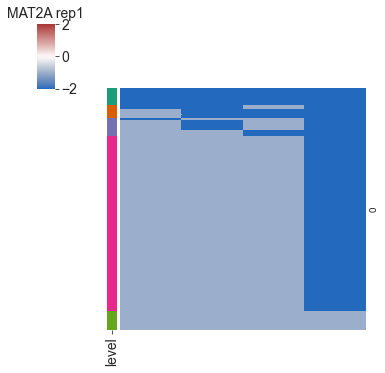

In [37]:
gene_name = "MAT2A"
replicate = "rep1"

sns.clustermap(MAT2A_mat1_bis, col_cluster=False, row_cluster=False, cmap="vlag", yticklabels=False, xticklabels=False, figsize=(5,5),
              row_colors=MAT2A_colors1, vmin=-2, vmax=2)

plt.title(gene_name + ' ' + replicate, fontsize=14)

plt.savefig("/path/to/plots/Fig2D_chromatin_rep1_MAT2A_read_heatmap_v2.pdf", format='pdf', dpi=300, bbox_inches='tight')


plt.show()

## Simulations for setting coverage threshold

In [1]:
# Function to compute splicing order
def get_score_per_path_non_consec(read_list, introns_of_interest_list):
    
    # Make a dictionary with the patterns and the counts and another with the number of introns spliced and the counts
    pattern_dict = {}
    results_list = []
    spliced_counts_dict = {}
    
    # Initiate pattern_dict
    pattern_dict = {}
    for n in range(len(introns_of_interest_list)+1):
        pattern_dict[n] = {}
    
    # Iterate to get counts for isoforms
    for read in read_list:
            splice_status_list = read.split("_")
            splice_status = "_".join(splice_status_list)
            spliced_count = Counter(splice_status_list)['YES']
            unspliced_count = Counter(splice_status_list)['NO']
            
            level = spliced_count
            if splice_status not in pattern_dict[level].keys():
                pattern_dict[level][splice_status] = 1
            elif splice_status in pattern_dict[level].keys():
                pattern_dict[level][splice_status] += 1
            if level not in spliced_counts_dict.keys():
                spliced_counts_dict[level] = 1
            else:
                spliced_counts_dict[level] += 1          
    
    # Filter for a certain number of reads at each intermediate level
    level_threshold = 0
    good_levels = []
    for level in sorted(list(spliced_counts_dict.keys()))[0:-1]: # exclude the final level (all spliced)
        if spliced_counts_dict[level] >= level_threshold:
            good_levels.append(level)
            
    if len(good_levels) == len(introns_of_interest_list): # there is at least one read at each level
        # Initiate path_dict
        path_dict = {}
        for n in range(len(introns_of_interest_list)):
            path_dict[n] = {}
        
        # For each combination of isoforms between levels (e.g. number of splicing events),
        # retrieve the frequencies and calculate scores
        # Below, the following scores are calculated:
        # freq: number of reads for that isoform / total number of reads for that level
        # sub_path_score : freq for that isoform * freq for the isoform from which it is derived
        # path_score: freq for that isoform * path_score from the previous isoform (so multiplicative frequencies)
        # full_path_score: the path_score for the last level of that path
        for levels in itertools.product(pattern_dict.keys(), pattern_dict.keys()):
            level1 = levels[0]
            level2 = levels[1]
            if level1 != level2: # we don't want to compare isoforms from the same level
            
                # Iterate through each pair of isoforms that are from different levels
                for pair in itertools.product(pattern_dict[level1].keys(), pattern_dict[level2].keys()):
                    pattern1 = pair[0].split("_")
                    pattern2 = pair[1].split("_")
        
                    # Get the splicing level of the isoform
                    unspliced_introns_pattern1 = len([i for i, x in enumerate(pattern1) if x == "NO"])
                    unspliced_introns_pattern2 = len([i for i, x in enumerate(pattern2) if x == "NO"])
                    spliced_introns_pattern2 = Counter(pattern2)['YES']
                
                    # Define the level that will be used below
                    level = level1
        
                    # retrieve the positions of the difference(s) between the two patterns
                    diff_index_list = [i for i, x in enumerate(pattern2) if pattern1[i]!=x]
        
                    # If pattern2 has one more spliced intron than pattern1:
                    if len(diff_index_list) == 1:
                        diff_index = diff_index_list[0]
                        if pattern1[diff_index] == "NO" and pattern2[diff_index] == "YES":
                            count_pattern1 = pattern_dict[level1][pair[0]]
                            count_pattern2 = pattern_dict[level2][pair[1]]
                
                            if level == 0: # this means we are starting from the unspliced isoform
                                # define a new splicing path
                                new_intron_spliced = str(introns_of_interest_list[diff_index])
                                path_name = new_intron_spliced + "->"
                                freq = count_pattern2 / spliced_counts_dict[level+1]
                                path_score = freq
                                sub_path_score = freq
                                path_dict[level][path_name] = [pattern1, pattern2, pair[0], pair[1], count_pattern1, count_pattern2, "spliced", level, new_intron_spliced, spliced_counts_dict[level+1], freq, sub_path_score, path_score]
                    
                            elif level > 0 and level < len(introns_of_interest_list)-1: # this means we are at an intermediate isoform
                                for k in path_dict[level-1].keys():
                                    if path_dict[level-1][k][1] == pattern1:
                                        new_intron_spliced = str(introns_of_interest_list[diff_index])
                                        if unspliced_introns_pattern2 == 0:
                                            path_name = str(k) + new_intron_spliced
                                        elif unspliced_introns_pattern2 > 0:
                                            path_name = str(k) + new_intron_spliced + "->"
                                        freq = count_pattern2 / spliced_counts_dict[level+1]
                                        path_score = path_dict[level-1][k][-1] * freq
                                        sub_path_score = path_dict[level-1][k][-3] * freq # only the frequency from the previous level and this level
                                        path_dict[level][path_name] = [pattern1, pattern2, pair[0], pair[1], count_pattern1, count_pattern2, "spliced", level, new_intron_spliced, spliced_counts_dict[level+1], freq, sub_path_score, path_score]
                            
                            elif level == len(introns_of_interest_list)-1: # this means we are at the fully spliced isoform        
                                for k in path_dict[level-1].keys():
                                    if path_dict[level-1][k][1] == pattern1:
                                        new_intron_spliced = str(introns_of_interest_list[diff_index])
                                        path_name = str(k) + new_intron_spliced
                                        freq = 1
                                        path_score = path_dict[level-1][k][-1] * freq
                                        sub_path_score = path_dict[level-1][k][-3] * freq
                                        path_dict[level][path_name] = [pattern1, pattern2, pair[0], pair[1], count_pattern1, count_pattern2, "spliced", level, new_intron_spliced, spliced_counts_dict[level+1], freq, sub_path_score, path_score]
    
        
        # Now loop through the dictionary to match each pair with the possible final paths
        # The final level contains only final paths, so first retrieve those
        try:
            final_level = list(path_dict.keys())[-1]
            final_level_df = pd.DataFrame.from_dict(path_dict[final_level], orient='index').reset_index()    
            final_level_df.columns = ['path_name','pattern1_list','pattern2_list','pattern1','pattern2','count_pattern1','count_pattern2','event_type','level','new_intron_spliced','total_counts_level','freq','sub_path_score','path_score']
            final_level_df = final_level_df.drop(['pattern1_list','pattern2_list'],axis=1)
            final_level_df['full_path'] = final_level_df['path_name']
            final_df = final_level_df.copy()
    
            # Iterate through each of the levels to match the partial paths with all the possible final paths
            for lev in list(reversed(list(path_dict.keys())))[:-1]:
                # For the two final levels, merge the second last with the last to retrieve the final path and add the final path score
                if lev == final_level:
                    df1 = pd.DataFrame.from_dict(path_dict[lev], orient='index').reset_index()
                    df2 = pd.DataFrame.from_dict(path_dict[lev-1], orient='index').reset_index()
        
                    df1.columns = ['path_name','pattern1_list','pattern2_list','pattern1','pattern2','count_pattern1','count_pattern2','event_type','level','new_intron_spliced','total_counts_level','freq','sub_path_score','path_score']
                    df2.columns = ['path_name','pattern1_list','pattern2_list','pattern1','pattern2','count_pattern1','count_pattern2','event_type','level','new_intron_spliced','total_counts_level','freq','sub_path_score','path_score']
        
                    fields = ['pattern1','path_name']
        
                    new_df = df2.merge(df1[fields], left_on='pattern2', right_on='pattern1', how='left')
                    new_df = new_df.rename(columns={'path_name_x':'path_name','path_name_y':'full_path','pattern1_x':'pattern1'}).drop(['pattern1_y','pattern1_list','pattern2_list'], axis=1)
            
                    new_df = new_df.fillna(0)
            
                    # If full_path is null, that means that it wasn't present in the level above and therefore the full path
                    # is likely to be the current path, so replace it that way
                    new_df_sub1 = new_df[new_df['full_path']==0].reset_index(drop=True)
                    new_df_sub2 = new_df[new_df['full_path']!=0].reset_index(drop=True)
            
                    new_df_sub1['full_path'] = new_df_sub1['path_name']
            
                    new_df = pd.concat([new_df_sub1, new_df_sub2]).reset_index(drop=True)
        
                    final_df = pd.concat([final_df, new_df]).reset_index(drop=True)
            
                # For any previous levels, repeat the previous steps
                elif (lev - 1) >= 0:
                    df1 = new_df.copy()
                    df2 = pd.DataFrame.from_dict(path_dict[lev-1], orient='index').reset_index()
        
                    df2.columns = ['path_name','pattern1_list','pattern2_list','pattern1','pattern2','count_pattern1','count_pattern2','event_type','level','new_intron_spliced','total_counts_level','freq','sub_path_score','path_score']
        
                    fields = ['pattern1','full_path']
        
                    new_df = df2.merge(df1[fields], left_on='pattern2', right_on='pattern1', how='left')
                    new_df = new_df.rename(columns={'pattern1_x':'pattern1'}).drop(['pattern1_y','pattern1_list','pattern2_list'], axis=1)
            
                    new_df = new_df.fillna(0)
            
                    new_df_sub1 = new_df[new_df['full_path']==0].reset_index(drop=True)
                    new_df_sub2 = new_df[new_df['full_path']!=0].reset_index(drop=True)
            
                    new_df_sub1['full_path'] = new_df_sub1['path_name']
            
                    new_df = pd.concat([new_df_sub1, new_df_sub2]).reset_index(drop=True)
        
                    final_df = pd.concat([final_df, new_df]).reset_index(drop=True)
            
            
            # Now make sure that the start of the full path is the same as the path name, since merging on patterns as above
            # will give rows where that is not the case
            final_final_df = final_df[final_df.apply(lambda row: row.full_path.startswith(row.path_name), axis=1)].drop_duplicates().sort_values(by='level').reset_index(drop=True)
    
    
            # Get the final score for the path and express it so that the total score of all final isoforms is 1
            last_isos = final_final_df[~final_final_df['path_name'].str.endswith("->")][['full_path','path_score']].drop_duplicates().reset_index(drop=True)
            #last_isos2 = final_final_df[(final_final_df['path_name']==final_final_df['full_path']) & (final_final_df['full_path'].str.endswith("->"))][['full_path','path_score']].drop_duplicates().reset_index(drop=True)
            #last_isos = pd.concat([last_isos1, last_isos2]).reset_index(drop=True)
            last_isos['full_path_score'] = last_isos['path_score'] / last_isos['path_score'].sum()
            last_isos = last_isos.drop('path_score',axis=1).sort_values(by='full_path_score', ascending=False).reset_index(drop=True)
            last_isos['rank'] = last_isos.index + 1
    
            # Modify the levels and rows where the unspliced isoform is pattern2
            final_final_df['level'] = final_final_df['level'] + 1
    
            NO_df = final_final_df[final_final_df['level']==1].reset_index(drop=True)
            NO_df['pattern2'] = NO_df['pattern1']
            NO_df['count_pattern2'] = NO_df['count_pattern1']
            NO_df['level'] = 0
            NO_df['new_intron_spliced'] = 0
    
            final_final_df = pd.concat([final_final_df,NO_df]).sort_values(by='level').reset_index(drop=True)
    
            final_final_df = final_final_df.merge(last_isos, on='full_path')[['full_path','full_path_score','rank']].drop_duplicates().sort_values(by='rank').reset_index(drop=True)
               
            return(final_final_df)
        
        except ValueError:
            pass
        

def get_random_reads(intron_list, probs, count_dict):

    random_reads = []

    for Level in count_dict.keys():
        for i in range(count_dict[Level]):
            spliced_introns = choice(intron_list, Level, p=probs, replace=False)
            read_splice_status = []
            for a in intron_list:
                if a not in spliced_introns:
                    read_splice_status.append("NO")
                elif a in spliced_introns:
                    read_splice_status.append("YES")
            read_splice_status_join = "_".join(read_splice_status)
            random_reads.append(read_splice_status_join)
            
    return(random_reads)


def Evenness(path_scores, max_paths):
    
    H = round(abs(np.sum(np.log(path_scores) * path_scores)),2) 
    max_H = round(np.log(max_paths),2)
    
    E = round(H/max_H,2)
    
    return(E)

In [4]:
# Simulate splicing and compute splicing order for groups of 3 introns
results_list = []

intron_list = [1,2,3]
# probabilities of each intron getting excised
prob_list = [[0.95,0.049,0.001],[0.85,0.14,0.01],[0.55,0.4,0.05],[0.4,0.35,0.25]]
n_iterations = 100

for probs in prob_list:
    for N in [2,5,10,20,30,40,50]:
        count_dict = {0:N, 1:N, 2:N, 3:N}
        for i in range(n_iterations):
            read_list = get_random_reads(intron_list, probs, count_dict)
            path_df = get_score_per_path_non_consec(read_list, intron_list)
            if path_df is not None:
                path_df['read_count'] = N
                scores = path_df[['full_path','full_path_score']].drop_duplicates()['full_path_score']
                E = Evenness(scores, math.factorial(len(probs)))
                path_df['Evenness'] = E
                probs_join = ",".join([str(a) for a in probs])
                path_df['probs'] = probs_join
                results_list.append(path_df)
    
results_df_triplets = pd.concat(results_list).reset_index(drop=True)


In [5]:
results_df_triplets.groupby(['probs'])['Evenness'].mean()

probs
0.4,0.35,0.25       0.866208
0.55,0.4,0.05       0.522327
0.85,0.14,0.01      0.320856
0.95,0.049,0.001    0.156798
Name: Evenness, dtype: float64

In [6]:
# Simulate splicing and compute splicing order for groups of 4 introns

results_list = []

intron_list = [1,2,3,4]
# probabilities of each intron getting excised
prob_list = [[0.95,0.039,0.01,0.001],[0.8,0.15,0.04,0.01],[0.5,0.3,0.15,0.05],[0.35,0.3,0.25,0.1]] # this is what we'll want to vary to look at different evenness values
n_iterations = 100

for probs in prob_list:
    for N in [2,5,10,20,30,40,50]:
        count_dict = {0:N, 1:N, 2:N, 3:N, 4:N}
        for i in range(n_iterations):
            read_list = get_random_reads(intron_list, probs, count_dict)
            path_df = get_score_per_path_non_consec(read_list, intron_list)
            if path_df is not None:
                path_df['read_count'] = N
                scores = path_df[['full_path','full_path_score']].drop_duplicates()['full_path_score']
                E = Evenness(scores, math.factorial(len(probs)))
                results_list.append(path_df)
                path_df['Evenness'] = E
                probs_join = ",".join([str(a) for a in probs])
                path_df['probs'] = probs_join
    
results_df_quads = pd.concat(results_list).reset_index(drop=True)

In [7]:
results_df_quads.groupby(['probs'])['Evenness'].mean()

probs
0.35,0.3,0.25,0.1        0.732549
0.5,0.3,0.15,0.05        0.580742
0.8,0.15,0.04,0.01       0.393794
0.95,0.039,0.01,0.001    0.264418
Name: Evenness, dtype: float64

In [8]:
results_df_triplets['n_introns'] = 3
results_df_quads['n_introns'] = 4
results_df = pd.concat([results_df_triplets,results_df_quads]).reset_index(drop=True)
results_df.to_csv("/path/to/splicing_order_simulations_for_coverage.txt", sep="\t", header=True, index=False)

## Comparison to nano-COP

In [10]:
# get the frequency of splicing order across reads that cover the same introns
def get_pair_splcing_frequencies(intron_pairs_df):

    pair_dict = {}

    for i in range(0,len(intron_pairs_df)):

        read = intron_pairs_df.iloc[i]['read']
        chrom = intron_pairs_df.iloc[i]['chrom']
        int1_start = intron_pairs_df.iloc[i]['int1_start']
        int1_end = intron_pairs_df.iloc[i]['int1_end']
        int2_start = intron_pairs_df.iloc[i]['int2_start']
        int2_end = intron_pairs_df.iloc[i]['int2_end']
        strand = intron_pairs_df.iloc[i]['strand']
        int1_splice = intron_pairs_df.iloc[i]['int1_splice']
        int2_splice = intron_pairs_df.iloc[i]['int2_splice']

        pair_coord = str(chrom)+"_"+str(int1_start)+"_"+str(int1_end)+"_"+str(int2_start)+"_"+str(int2_end)+"_"+str(strand)

        if (strand == "-"):
            x = int1_splice
            int1_splice = int2_splice
            int2_splice = x

        if pair_coord not in pair_dict.keys():

            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [1,0,0,0]

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,1,0,0]

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord] = [0,0,1,0]

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord] = [0,0,0,1]

        elif pair_coord in pair_dict.keys():
            if (int1_splice=="YES") & (int2_splice=="YES"):
                pair_dict[pair_coord][0] += 1

            if (int1_splice=="YES") & (int2_splice=="NO"):
                pair_dict[pair_coord][1] += 1

            if (int1_splice=="NO") & (int2_splice=="YES"):
                pair_dict[pair_coord][2] += 1

            if (int1_splice=="NO") & (int2_splice=="NO"):
                pair_dict[pair_coord][3] += 1

    pair_df = pd.DataFrame.from_dict(pair_dict, orient='index')
    pair_df.columns = ['YES_YES','YES_NO','NO_YES','NO_NO']   

    return pair_df

In [11]:
# Load nano-COP data
K562_intron_pairs_df = pd.read_table("/path/to/K562_all_nanoCOP_hg38_intron_pairs_df.txt", dtype={'chrom':'str'})


In [12]:
# get intron pair splicing order frequencies for nano-COP
K562_pair_spicing_freq = get_pair_splcing_frequencies(K562_intron_pairs_df)

In [13]:
read_threshold = 10

top_K562_pair_spicing_freq = K562_pair_spicing_freq.copy()[K562_pair_spicing_freq['YES_NO']+K562_pair_spicing_freq['NO_YES'] >= read_threshold]

top_K562_pair_spicing_freq['intron_coord'] = top_K562_pair_spicing_freq.index

top_K562_pair_spicing_freq = top_K562_pair_spicing_freq.reset_index(drop=True)
top_K562_pair_spicing_freq['chrom'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[0]
top_K562_pair_spicing_freq['start1'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[1].astype(int)
top_K562_pair_spicing_freq['end1'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[2].astype(int)
top_K562_pair_spicing_freq['start2'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[3].astype(int)
top_K562_pair_spicing_freq['end2'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[4].astype(int)
top_K562_pair_spicing_freq['strand'] = top_K562_pair_spicing_freq['intron_coord'].str.split("_").str[5]

In [14]:
# Load polyA+ chromatin RNA-seq data
repA_intron_pairs_df = pd.read_table("/path/to/K562_chr_repA_merged_hg38_intron_pairs_df.RefSeq.txt", dtype={'chrom':'str'})
repB_intron_pairs_df = pd.read_table("/path/to/K562_chr_repB_merged_hg38_intron_pairs_df.RefSeq.txt", dtype={'chrom':'str'})


In [15]:
# Merge polyA+ pairs with nano-COP pairs
fields = ['chrom','start1','end1','start2','end2','strand']
repA_intron_pairs_df_sub = repA_intron_pairs_df.merge(top_K562_pair_spicing_freq, left_on=['chrom','int1_start','int1_end','int2_start','int2_end','strand'], right_on=['chrom','start1','end1','start2','end2','strand'])
repB_intron_pairs_df_sub = repB_intron_pairs_df.merge(top_K562_pair_spicing_freq, left_on=['chrom','int1_start','int1_end','int2_start','int2_end','strand'], right_on=['chrom','start1','end1','start2','end2','strand'])

In [16]:
# get intron pair splicing order frequencies for polyA+ data
repA_pair_spicing_freq = get_pair_splcing_frequencies(repA_intron_pairs_df_sub)
repA_pair_spicing_freq['intron_coord'] = repA_pair_spicing_freq.index

repB_pair_spicing_freq = get_pair_splcing_frequencies(repB_intron_pairs_df_sub)
repB_pair_spicing_freq['intron_coord'] = repB_pair_spicing_freq.index

In [17]:
# Filter for minimum read coverage
repA_pair_spicing_filt = repA_pair_spicing_freq[repA_pair_spicing_freq['YES_NO']+repA_pair_spicing_freq['NO_YES'] >= read_threshold]
repB_pair_spicing_filt = repB_pair_spicing_freq[repB_pair_spicing_freq['YES_NO']+repB_pair_spicing_freq['NO_YES'] >= read_threshold]

# Merge results together
both_df = top_K562_pair_spicing_freq.merge(repA_pair_spicing_filt, on='intron_coord').merge(repB_pair_spicing_filt, on='intron_coord')

# Write to file for further plotting in R
both_df.to_csv("/path/to/K562_nanoCOP_vs_polyA_intron_pairs.txt", sep="\t", header=True, index=False)